In [1]:
#импортируем все, что нужно
import math
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D,AveragePooling2D,Conv2DTranspose, Input, Concatenate, Add, BatchNormalization, Activation, MultiHeadAttention
import tensorflow_hub as hub
import tensorflow_text as text
from ipywidgets import IntProgress
from IPython.display import display

In [2]:
#bert
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
bert_model = hub.KerasLayer(tfhub_handle_encoder)

def process_text(text_batch):
    text_preprocessed = bert_preprocess_model(text_batch)
    bert_results = bert_model(text_preprocessed)
    return bert_results["pooled_output"]

In [3]:
#апскейлер от tensorflow. довольно кривой.
SAVED_MODEL_PATH = "https://tfhub.dev/captain-pool/esrgan-tf2/1"
model_upscaler = hub.load(SAVED_MODEL_PATH)

In [4]:
import numpy as np
import tensorflow as tf

class GaussianDiffusion:
    """Утилита для гауссовского диффузии.

    Args:
        beta_start: Начальное значение дисперсии
        beta_end: Конечное значение дисперсии
        timesteps: Количество временных шагов в процессе прямой, а затем обратной диффузии
    """

    def __init__(
        self, beta_start=1e-4, beta_end=0.02, timesteps=1000, clip_min=-1.0, clip_max=1.0):
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.timesteps = timesteps
        self.clip_min = clip_min
        self.clip_max = clip_max

        # Определение линейного расписания дисперсии
        self.betas = betas = np.linspace(
            beta_start,
            beta_end,
            timesteps,
            dtype=np.float64,  # Тут используется float64 для лучшей точности
        )
        self.num_timesteps = int(timesteps)

        alphas = 1.0 - betas
        alphas_cumprod = np.cumprod(alphas, axis=0)
        alphas_cumprod_prev = np.append(1.0, alphas_cumprod[:-1])

        self.betas = tf.constant(betas, dtype=tf.float32)
        self.alphas_cumprod = tf.constant(alphas_cumprod, dtype=tf.float32)
        self.alphas_cumprod_prev = tf.constant(alphas_cumprod_prev, dtype=tf.float32)

        # Расчеты для диффузии q(x_t | x_{t-1}) и других
        self.sqrt_alphas_cumprod = tf.constant(np.sqrt(alphas_cumprod), dtype=tf.float32)

        self.sqrt_one_minus_alphas_cumprod = tf.constant(np.sqrt(1.0 - alphas_cumprod), dtype=tf.float32)

        self.log_one_minus_alphas_cumprod = tf.constant(np.log(1.0 - alphas_cumprod), dtype=tf.float32)

        self.sqrt_recip_alphas_cumprod = tf.constant(np.sqrt(1.0 / alphas_cumprod), dtype=tf.float32)
        self.sqrt_recipm1_alphas_cumprod = tf.constant(np.sqrt(1.0 / alphas_cumprod - 1), dtype=tf.float32)

        # Расчеты для апостериорной q(x_{t-1} | x_t, x_0)
        posterior_variance = (betas * (1.0 - alphas_cumprod_prev) / (1.0 - alphas_cumprod))
        self.posterior_variance = tf.constant(posterior_variance, dtype=tf.float32)

        # Обрезка расчета логарифма, так как апостериорная дисперсия равна 0 в начале цепочки диффузии
        self.posterior_log_variance_clipped = tf.constant(np.log(np.maximum(posterior_variance, 1e-20)), dtype=tf.float32)

        self.posterior_mean_coef1 = tf.constant(betas * np.sqrt(alphas_cumprod_prev) / (1.0 - alphas_cumprod),dtype=tf.float32,)

        self.posterior_mean_coef2 = tf.constant(
            (1.0 - alphas_cumprod_prev) * np.sqrt(alphas) / (1.0 - alphas_cumprod),dtype=tf.float32)

    def _extract(self, a, t, x_shape):
        """Извлекает некоторые коэффициенты в указанных временных шагах,
        затем изменяет форму на [batch_size, 1, 1, 1, 1, ...] совпадения форм.

        Args:
            a: Тензор для извлечения
            t: Временной шаг, для которого коэффициенты должны быть извлечены
            x_shape: Форма текущих выборок в батче
        """
        batch_size = x_shape[0]
        out = tf.gather(a, t)
        return tf.reshape(out, [batch_size, 1, 1, 1])

    def q_mean_variance(self, x_start, t):
        """Извлекает среднее значение и дисперсию на текущем временном шаге.

        Args:
            x_start: Начальный образец (перед первым шагом диффузии)
            t: Текущий временной шаг
        """
        x_start_shape = tf.shape(x_start)
        mean = self._extract(self.sqrt_alphas_cumprod, t, x_start_shape) * x_start
        variance = self._extract(1.0 - self.alphas_cumprod, t, x_start_shape)
        log_variance = self._extract(self.log_one_minus_alphas_cumprod, t, x_start_shape)
        return mean, variance, log_variance

    def q_sample(self, x_start, t, noise):
        """Диффузия данных.

        Args:
            x_start: Начальный образец (перед первым шагом диффузии)
            t: Текущий временной шаг
            noise: Добавляемый гауссовский шум на текущем временном шаге
        Returns:
            Диффузионные образцы на временном шаге `t`
        """
        x_start_shape = tf.shape(x_start)
        
        return (
            self._extract(self.sqrt_alphas_cumprod, t, tf.shape(x_start)) * x_start
            + self._extract(self.sqrt_one_minus_alphas_cumprod, t, x_start_shape)
            * noise
        )

    def predict_start_from_noise(self, x_t, t, noise):
        x_t_shape = tf.shape(x_t)
        
        return (
            self._extract(self.sqrt_recip_alphas_cumprod, t, x_t_shape) * x_t
            - self._extract(self.sqrt_recipm1_alphas_cumprod, t, x_t_shape) * noise
        )

    def q_posterior(self, x_start, x_t, t):
        """Вычисляет среднее значение и дисперсию диффузии апостериорной q(x_{t-1} | x_t, x_0).

        Args:
            x_start: Точка начала (образец) для вычисления апостериори
            x_t: Образец на временном шаге `t`
            t: Текущий временной шаг
        Returns:
            Апостериорное среднее значение и дисперсия на текущем временном шаге
        """

        x_t_shape = tf.shape(x_t)
        posterior_mean = (
            self._extract(self.posterior_mean_coef1, t, x_t_shape) * x_start
            + self._extract(self.posterior_mean_coef2, t, x_t_shape) * x_t
        )
        posterior_variance = self._extract(self.posterior_variance, t, x_t_shape)
        posterior_log_variance_clipped = self._extract(self.posterior_log_variance_clipped, t, x_t_shape)
        
        return posterior_mean, posterior_variance, posterior_log_variance_clipped

    def p_mean_variance(self, pred_noise, x, t, clip_denoised=True):
        x_recon = self.predict_start_from_noise(x, t=t, noise=pred_noise)
        if clip_denoised:
            x_recon = tf.clip_by_value(x_recon, self.clip_min, self.clip_max)

        model_mean, posterior_variance, posterior_log_variance = self.q_posterior(x_start=x_recon, x_t=x, t=t)
        
        return model_mean, posterior_variance, posterior_log_variance

    def p_sample(self, pred_noise, x, t, clip_denoised=True):
        """Выборка из модели диффузии.

        Args:
            pred_noise: Шум, предсказанный моделью диффузии
            x: Образцы на определенном временном шаге, для которого был предсказан шум
            t: Текущий временной шаг
            clip_denoised (bool): Нужно ли обрезать предсказанный шум в указанном диапазоне или нет.
        """
        model_mean, _, model_log_variance = self.p_mean_variance(pred_noise, x=x, t=t, clip_denoised=clip_denoised)
        noise = tf.random.normal(shape=x.shape, dtype=x.dtype)
        # Нет шума, когда t == 0
        nonzero_mask = tf.reshape(1 - tf.cast(tf.equal(t, 0), tf.float32), [tf.shape(x)[0], 1, 1, 1])
        
        return model_mean + nonzero_mask * tf.exp(0.5 * model_log_variance) * noise

    
class DiffusionModel(keras.Model):
    def __init__(self, network, ema_network, timesteps, gdf_util, ema=0.999):
        super().__init__()
        self.network = network
        self.ema_network = ema_network
        self.timesteps = timesteps
        self.gdf_util = gdf_util
        self.ema = ema


    def generate_images(self, num_images=16, annotation = " "):
        
        # 1. Преобразуем текст в эмбеддинг
        annotation = tf.expand_dims(annotation, axis = 0)
        embedding = process_text(annotation)
        embedding = tf.expand_dims(embedding, axis = 0)
        embeddings = tf.repeat(embedding, num_images , axis = 0)
        
        # 2. Берем случайный шум
        samples = tf.random.normal(shape=(num_images, image_size, image_size, img_channels), dtype=tf.float32)
        
        # 3. Применяем к нему нейросеть несколько раз
        bar = IntProgress(min=0, max=self.timesteps) #прогресс-бар
        display(bar)
        for t in reversed(range(0, self.timesteps)):
            bar.value+=1
            tt = tf.cast(tf.fill(num_images, t), dtype=tf.int64)
            pred_noise = self.ema_network.predict([samples, tf.reshape(tt, shape = (-1, 1,1,1)), tf.reshape(embeddings, shape = (-1, 1,1,512))], verbose=0, batch_size=num_images)
            samples = self.gdf_util.p_sample(pred_noise, samples, tt, clip_denoised=True)
            
        #если нужен апскейлер
        #samples = model_upscaler(samples * 127 + 127)
        samples = tf.image.resize(samples*127+127, (256, 256), method = 'bilinear')
        
        return samples

    def plot_images(self, epoch=None, logs=None, num_rows=2, num_cols=8, figsize=(12, 5), annotation = " "):
        
        generated_samples = self.generate_images(num_images=num_rows * num_cols, annotation = annotation)
        generated_samples = (tf.clip_by_value(generated_samples, 0.0, 255.0).numpy().astype(np.uint8))
        

        _, ax = plt.subplots(num_rows, num_cols, figsize=figsize)
        for i, image in enumerate(generated_samples):
            if num_rows == 1:
                ax[i].imshow(image)
                ax[i].axis("off")
            else:
                ax[i // num_cols, i % num_cols].imshow(image)
                ax[i // num_cols, i % num_cols].axis("off")

        plt.tight_layout()
        plt.show()
        return generated_samples

In [5]:
total_timesteps = 500

# Get an instance of the Gaussian Diffusion utilities
gdf_util = GaussianDiffusion(timesteps=total_timesteps)

#устанавливаем то, что не сохраняется в h5 файл
embedding_dims = 32
embedding_max_frequency = 1000.0
image_size = 64
img_channels = 3

network = tf.keras.models.load_model('kt_diffision_v2.1_s.h5')

# Get the model
model = DiffusionModel(network=network, ema_network=network, gdf_util=gdf_util, timesteps=total_timesteps)

IntProgress(value=0, max=500)

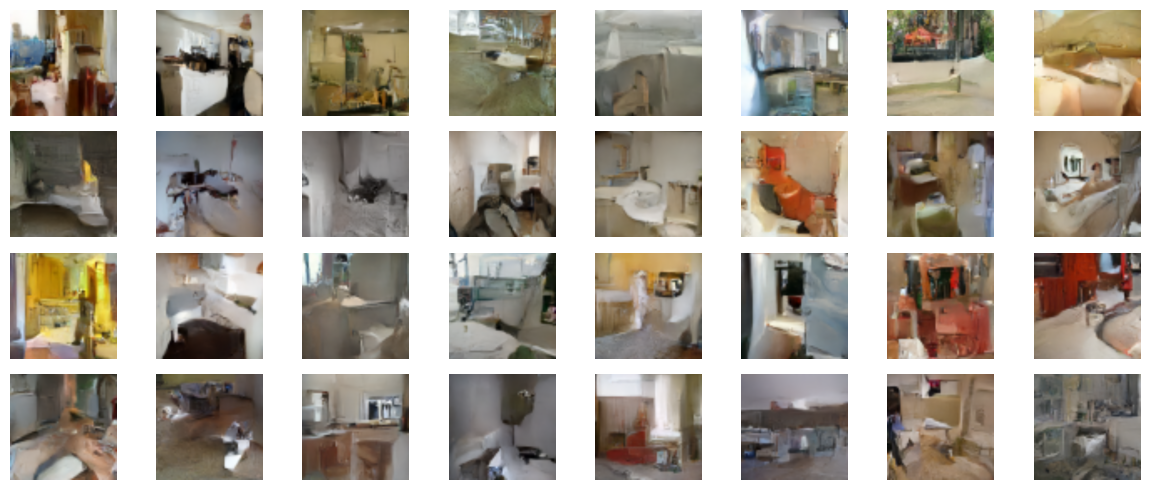

In [6]:
_ = model.plot_images(num_rows=4, num_cols=8, annotation = "A clean empty bedroom with a bed")

IntProgress(value=0, max=500)

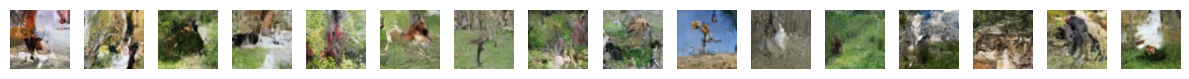

Saved as Image.jpg


In [6]:
#картинку нужно сохранить, чтобы отправить через бота
def save_image(image, filename):
    if not isinstance(image, Image.Image):
        image = tf.clip_by_value(image, 0, 255)
        image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
        image.save("%s.jpg" % filename)
        print("Saved as %s.jpg" % filename)
    
    
from PIL import Image    
import telebot
from telebot import types

#ключ к боту
bot = telebot.TeleBot('6032610305-- some code --mPA9oU4s4c')

@bot.message_handler(commands=['start'])
def start(message):

    markup = types.ReplyKeyboardMarkup(resize_keyboard=True)
    bot.send_message(message.from_user.id, "Здравствуй! Напиши запрос сюда", reply_markup=markup)

@bot.message_handler(content_types=['text'])
def get_text_messages(message):

    if message.text == 'Запрос':
        bot.send_message(message.from_user.id, 'ответ', parse_mode='Markdown')
        
    else:
        bot.send_message(message.from_user.id, 'Идет генерация. Подождите около 30 сек.', parse_mode='Markdown')
        images = model.plot_images(num_rows=1, num_cols=16, annotation = message.text)
        image = np.zeros((1024, 1024, 3), dtype = np.float32)
        for x in range(4):
            for y in range(4):
                index = x*4 + y
                image[x*256:x*256+256, y*256:y*256+256, :] = images[index]
        
        
        save_image(image, filename="Image")
        img = open('Image.jpg', 'rb')
        bot.send_photo(message.chat.id, img)
        bot.send_message(message.from_user.id, 'Результат по запросу: '+ message.text, parse_mode='Markdown')

bot.polling(none_stop=True, interval=0) 